## Required libraries:

In [ ]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd

# sklearn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn import set_config
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize = (12, 5))

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load processed Data Frame of Bicing: 2019-2022**
All data processement can be check on file:

[01_DF_creation_Station&Bicing_info](https://colab.research.google.com/drive/1L4QHje5e7tBrphzDqBJ0FZrVmALJmC0g?usp=sharing)


In [ ]:
df = pd.read_csv('/content/drive/My Drive/CapstoneProject_NathyDani/df_final.csv')

In [ ]:
df.shape

(2950003, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950003 entries, 0 to 2950002
Data columns (total 18 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   station_id                  int64  
 1   lat                         float64
 2   lon                         float64
 3   altitude                    float64
 4   address                     object 
 5   post_code                   int64  
 6   capacity                    int64  
 7   date                        object 
 8   year                        int64  
 9   month                       int64  
 10  day                         int64  
 11  day_of_week                 int64  
 12  hour                        int64  
 13  percentage_docks_available  float64
 14  ctx-4                       float64
 15  ctx-3                       float64
 16  ctx-2                       float64
 17  ctx-1                       float64
dtypes: float64(8), int64(8), object(2)
memory usage: 405.1+ MB


In [ ]:
df.head()

,station_id,lat,lon,altitude,address,post_code,capacity,date,year,month,day,day_of_week,hour,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1
0,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,1,5,4,0.72,0.68,0.73,0.74,0.72
1,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,1,5,9,0.58,0.67,0.63,0.62,0.61
2,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,1,5,14,0.75,0.62,0.67,0.74,0.75
3,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,1,5,19,0.65,0.76,0.72,0.69,0.68
4,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-02,2022,1,2,6,0,0.59,0.66,0.68,0.66,0.59


# **Delete covid lockdown**
Lockdown months of 2020 should be disregarded in the training model

In [ ]:
#Check how many data we have for each month of 2020... it seems only months 3 and 4 have low data.
#Should we delete only March and April?
months = np.arange(1, 13, 1)
number_list = []
for i in months:
  number = len(df[(df["year"]== 2020) & (df["month"]== i)])
  #print(number)
  number_list.append(number)

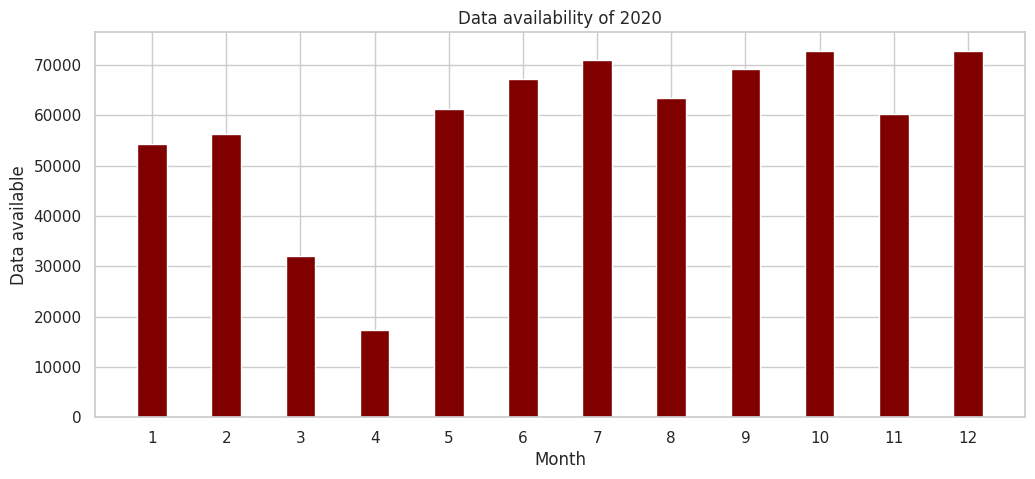

In [ ]:
plt.bar(months, number_list, color ='maroon', width = 0.4)
plt.xlabel('Month')
plt.ylabel('Data available')
plt.xticks(months)
plt.title('Data availability of 2020')
plt.show()

In [ ]:
#initially we will delete only the months of march and april of 2020 (first lockdown)
df_model = df.drop(df[(df['year'] == 2020) & (df['month'] == 3) | (df['year'] == 2020) & (df['month'] == 4)].index)

In [ ]:
#check if was removed
((df_model['year'] == 2020) & (df_model['month'] == 3)).any()

False

In [ ]:
#check if df original still has covid months
((df['year'] == 2020) & (df['month'] == 3)).any()

True

###Test for training the model only with data from 2021 and 2022:

In [ ]:
df_21_22 = df.drop(df[(df['year'] == 2019) | (df['year'] == 2020)].index)
df_21_22['year'].unique()

array([2022, 2021])

In [ ]:
df_21_22.shape

(1741843, 18)

###Test for training the model only with stations that we will predict in kaggle:

In [ ]:
# kaggle_set = pd.read_csv('/content/drive/My Drive/CapstoneProject_NathyDani/kaggle_set.csv')

In [ ]:
# print(kaggle_set_csv['station_id'].nunique())
# print(df_final['station_id'].nunique())
# print(df_station_reduced['station_id'].nunique())

In [ ]:
# df_model_kaggle = df[df['station_id'].isin(kaggle_set['station_id'].unique())]
# df_model_kaggle.info()

###Test for training the model with labels:

In [ ]:
labels = pd.read_csv('/content/drive/My Drive/CapstoneProject_NathyDani/df_labels.csv')

In [ ]:
labels

,station_id,label
0,1,1
1,2,1
2,3,1
3,4,3
4,5,1
...,...,...
502,515,2
503,516,3
504,517,3
505,518,2


In [ ]:
df_labels = pd.merge(df_21_22, labels, on='station_id', how='left')

In [ ]:
df_labels

,station_id,lat,lon,altitude,address,post_code,capacity,date,year,month,day,day_of_week,hour,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1,label
0,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,1,5,4,0.72,0.68,0.73,0.74,0.72,1.0
1,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,1,5,9,0.58,0.67,0.63,0.62,0.61,1.0
2,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,1,5,14,0.75,0.62,0.67,0.74,0.75,1.0
3,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,1,5,19,0.65,0.76,0.72,0.69,0.68,1.0
4,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-02,2022,1,2,6,0,0.59,0.66,0.68,0.66,0.59,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741838,519,41.424655,2.166289,110.0,"C/ PEDRELL, 52",8032,24,2021-12-31,2021,12,31,4,1,0.62,0.97,0.88,0.77,0.65,2.0
1741839,519,41.424655,2.166289,110.0,"C/ PEDRELL, 52",8032,24,2021-12-31,2021,12,31,4,6,0.62,0.61,0.58,0.58,0.61,2.0
1741840,519,41.424655,2.166289,110.0,"C/ PEDRELL, 52",8032,24,2021-12-31,2021,12,31,4,11,0.78,0.64,0.63,0.67,0.70,2.0
1741841,519,41.424655,2.166289,110.0,"C/ PEDRELL, 52",8032,24,2021-12-31,2021,12,31,4,16,0.97,0.83,0.88,0.91,0.92,2.0


## Selecting columns:

In [ ]:
corr_matrix = df_model.corr()
corr_matrix['percentage_docks_available'].sort_values(ascending=False)

<ipython-input-12-7ac441ddf6ee>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_model.corr()


percentage_docks_available    1.000000
ctx-1                         0.913026
ctx-2                         0.797553
ctx-3                         0.695773
ctx-4                         0.605141
altitude                      0.361486
lat                           0.077631
station_id                    0.074272
year                          0.048495
month                         0.041075
hour                          0.025595
day                           0.000436
post_code                    -0.001460
day_of_week                  -0.015170
capacity                     -0.030357
lon                          -0.276516
Name: percentage_docks_available, dtype: float64

In [ ]:
corr_matrix.style.background_gradient(cmap='coolwarm')

,station_id,lat,lon,altitude,post_code,capacity,year,month,day,day_of_week,hour,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1
station_id,1.000000,0.079632,-0.164387,0.212677,-0.023833,0.091070,0.001717,-0.000779,0.000329,-0.000122,-0.000214,0.074272,0.074379,0.074697,0.074761,0.074805
lat,0.079632,1.000000,0.463897,0.214408,0.113635,-0.073958,0.001089,0.000044,0.000200,-0.000080,-0.000408,0.077631,0.077338,0.077478,0.077569,0.077675
lon,-0.164387,0.463897,1.000000,-0.653279,0.039405,0.096593,-0.000015,0.000080,0.000042,-0.000136,0.000025,-0.276516,-0.276349,-0.276399,-0.276653,-0.276747
altitude,0.212677,0.214408,-0.653279,1.000000,0.048945,-0.111080,0.000131,-0.000178,-0.000007,-0.000015,-0.000192,0.361486,0.361082,0.361085,0.361309,0.361429
post_code,-0.023833,0.113635,0.039405,0.048945,1.000000,0.211234,-0.000187,-0.000018,0.000236,0.000066,-0.000106,-0.001460,-0.001490,-0.001653,-0.001678,-0.001594
capacity,0.091070,-0.073958,0.096593,-0.111080,0.211234,1.000000,-0.003714,0.000234,-0.000021,-0.000471,-0.000208,-0.030357,-0.030266,-0.030501,-0.030711,-0.030468
year,0.001717,0.001089,-0.000015,0.000131,-0.000187,-0.003714,1.000000,-0.159714,-0.005984,0.006063,-0.000387,0.048495,0.048683,0.048776,0.048683,0.048368
month,-0.000779,0.000044,0.000080,-0.000178,-0.000018,0.000234,-0.159714,1.000000,0.002380,-0.010807,0.000039,0.041075,0.040927,0.041050,0.040700,0.040832
day,0.000329,0.000200,0.000042,-0.000007,0.000236,-0.000021,-0.005984,0.002380,1.000000,0.000944,-0.002866,0.000436,-0.000166,0.000303,0.000538,0.000287
day_of_week,-0.000122,-0.000080,-0.000136,-0.000015,0.000066,-0.000471,0.006063,-0.010807,0.000944,1.000000,-0.001935,-0.015170,-0.014425,-0.015176,-0.015129,-0.015297


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900638 entries, 0 to 2950002
Data columns (total 18 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   station_id                  int64  
 1   lat                         float64
 2   lon                         float64
 3   altitude                    float64
 4   address                     object 
 5   post_code                   int64  
 6   capacity                    int64  
 7   date                        object 
 8   year                        int64  
 9   month                       int64  
 10  day                         int64  
 11  day_of_week                 int64  
 12  hour                        int64  
 13  percentage_docks_available  float64
 14  ctx-4                       float64
 15  ctx-3                       float64
 16  ctx-2                       float64
 17  ctx-1                       float64
dtypes: float64(8), int64(8), object(2)
memory usage: 420.5+ MB


In [ ]:
df_model.shape

(2900638, 18)

## Dividing the dataframe into train_set and test_set:
80% train, 20% test

In [ ]:
# # split df_final using the scikit learn function
# train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)
# print(train_set.shape)
# print(test_set.shape)


# # df_21_22
# train_set, test_set = train_test_split(df_21_22, test_size=0.2, random_state=42)
# print(train_set.shape)
# print(test_set.shape)

# df_labels
train_set, test_set = train_test_split(df_labels, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(1393474, 19)
(348369, 19)


#Preparing the data frame for machine learning:

In [ ]:
# # for faster results, we will initially use only a percentage of the dataframe
# # !! delete later !!
# train_set = train_set.sample(frac = 0.5)
# train_set.shape

### Pipelines:

In [ ]:
#Pipeline: numerical variables
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), #normalize data
    ])

#Pipeline: categorical variables
cat_pipeline = Pipeline([
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

In [ ]:
#define categorical columns
cat_columns = ['day_of_week', 'label']

#define numerical columns
num_columns = ['altitude', 'hour', 'month', 'lat', 'lon']

#columns to be included with no transformation
include_columns = ['ctx-1' , 'ctx-2' , 'ctx-3' , 'ctx-4'] #, 'hour', 'month', 'lat', 'lon'

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_columns),
        ("cat", cat_pipeline, cat_columns),
        ('pass', "passthrough", include_columns)
    ])

prepared_train_set = full_pipeline.fit_transform(train_set)

In [ ]:
prepared_train_set.shape

(1393474, 21)

# Select and train a model:

In [ ]:
# split train_set into X and y
X = prepared_train_set
y = train_set['percentage_docks_available'].copy() #labels

print(X.shape)
print(y.shape)

(1393474, 21)
(1393474,)


In [ ]:
# # models to test
# models = [LinearRegression(),
#           #DecisionTreeRegressor(),
#           RandomForestRegressor(),
#           MLPRegressor(),
#           #GradientBoostingRegressor(),
#           #neighbors.KNeighborsRegressor()
#           ]

In [ ]:
# from sklearn import model_selection
# def train(model):
#   kfold = model_selection.KFold(n_splits=5)
#   pred = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
#   cv_score = pred.mean()
#   print('Model:', model)
#   print('CV score:', abs(cv_score))

In [ ]:
# for model in models:
#   train(model)

Model: LinearRegression()
CV score: 0.10890175935901263
Model: RandomForestRegressor()
CV score: 0.10496254614254322
Model: MLPRegressor()
CV score: 0.1147683967557543


Comparing the results, RandomForestRegressor seems to be the most efficient model.

Let's find the best parameters:

In [ ]:
# # split data to train and test
# # divide using the scikit learn function
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(1114779, 16)
(278695, 16)
(1114779,)
(278695,)


In [ ]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8], 'max_depth':[3,5,7,10]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [3, 5, 7, 10],
                          'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
# print("The best parameters are:")
# print(grid_search.best_params_)

In [ ]:
params = {'max_depth': 10, 'max_features': 8, 'n_estimators': 30}
model = RandomForestRegressor(**params)

In [ ]:
# model = grid_search.best_estimator_
model.fit(X, y)
# y_pred = model.predict(X_test)

RandomForestRegressor(max_depth=10, max_features=8, n_estimators=30)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.10507730469536355

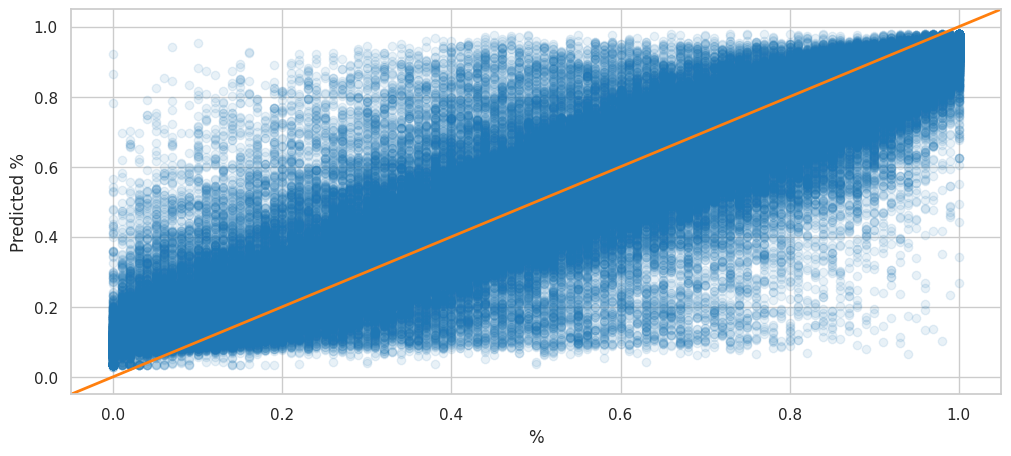

In [ ]:
plt.scatter(y_test, y_pred, c='C0', alpha=0.1)
plt.axline((0,0),(1,1), c='C1')
plt.xlabel('%')
plt.ylabel('Predicted %');
plt.show()

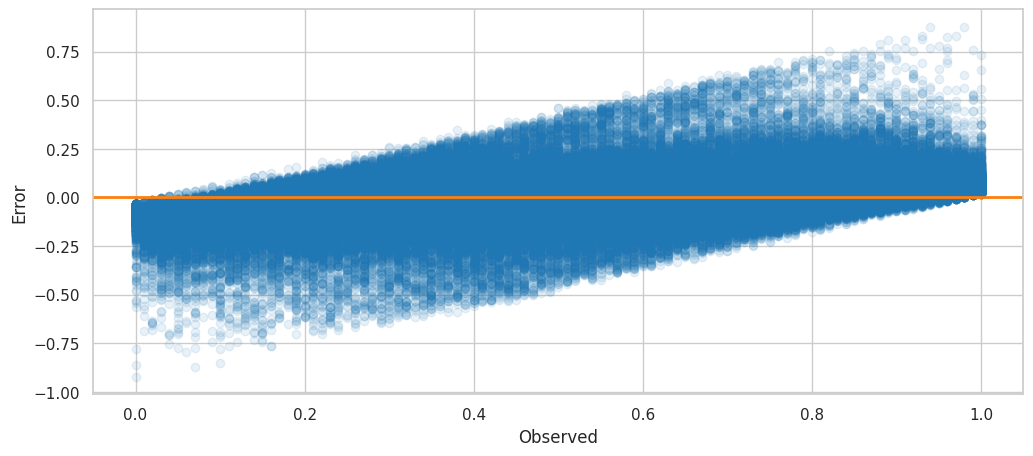

In [ ]:
# to check error difference
error = y_test - y_pred
fig, ax = plt.subplots()
ax.scatter(y_test, error, c='C0', alpha=0.1)
ax.axhline(c='C1')
ax.set_xlabel('Observed')
ax.set_ylabel('Error')
plt.show()

___
## Final model:
Here we will evaluate our model on the test_set.

In [ ]:
final_model = grid_search.best_estimator_
# final_model = model

X_test_set = full_pipeline.fit_transform(test_set)
y_test_set = test_set['percentage_docks_available'].copy() #labels

final_predictions = final_model.predict(X_test_set)

In [ ]:
final_mse = mean_squared_error(y_test_set, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

0.10573747402006844

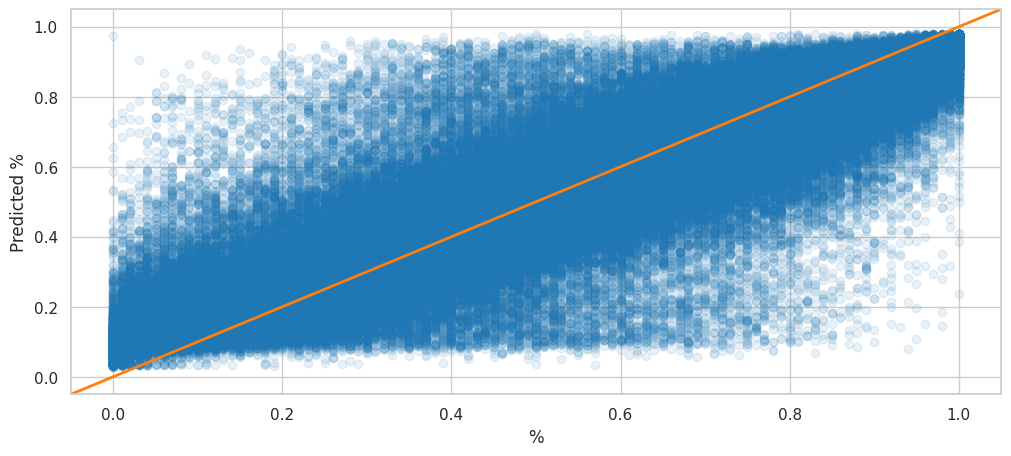

In [ ]:
plt.scatter(y_test_set, final_predictions, c='C0', alpha=0.1)
plt.axline((0,0),(1,1), c='C1')
plt.xlabel('%')
plt.ylabel('Predicted %');
plt.show()

___
## Data from Kaggle:
To predict the test set and generate the submission file

In [ ]:
kaggle_set = pd.read_csv('/content/drive/My Drive/CapstoneProject_NathyDani/kaggle_set.csv')
kaggle_set

,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,year,day_of_week
0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,41.387306,2.163126,25.0,2023,1
1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,41.398624,2.120494,117.0,2023,3
2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,41.396839,2.175660,21.0,2023,4
3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,41.405007,2.134603,114.0,2023,3
4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,41.402988,2.134469,106.0,2023,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,41.448152,2.192940,26.0,2023,1
54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,41.413866,2.177727,49.0,2023,2
54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,41.367557,2.138822,14.0,2023,0
54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,41.408211,2.168996,60.0,2023,1


In [ ]:
kaggle_set_labels = pd.merge(kaggle_set, labels, on='station_id', how='left')

In [ ]:
kaggle_set_labels.describe()

,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,year,day_of_week,label
count,54999.000000,54999.0,54999.000000,54999.000000,54999.000000,54999.000000,54999.000000,54999.000000,54999.000000,54999.000000,54999.000000,54999.0,54999.000000,54856.000000
mean,216.161639,3.0,15.517009,11.533682,0.571921,0.571794,0.571857,0.571432,41.396774,2.169543,29.164221,2023.0,2.914871,1.577640
std,124.601964,0.0,8.867172,6.878081,0.269534,0.269224,0.269640,0.269843,0.018436,0.024414,26.425112,0.0,1.856078,1.017676
min,1.000000,3.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.357067,2.111541,2.000000,2023.0,0.000000,0.000000
25%,110.000000,3.0,8.000000,6.000000,0.370370,0.370370,0.370370,0.370370,41.383365,2.151038,7.000000,2023.0,1.000000,1.000000
50%,217.000000,3.0,15.000000,12.000000,0.604167,0.604938,0.604938,0.604938,41.393582,2.173501,22.000000,2023.0,3.000000,2.000000
75%,322.000000,3.0,23.000000,17.000000,0.801282,0.800000,0.800000,0.800000,41.406529,2.188449,41.000000,2023.0,4.000000,2.000000
max,496.000000,3.0,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,41.450608,2.220691,121.000000,2023.0,6.000000,3.000000


In [ ]:
X_kaggle_set = full_pipeline.fit_transform(kaggle_set_labels)

final_predictions = final_model.predict(X_kaggle_set)

In [ ]:
df_output = pd.DataFrame(final_predictions)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']
df_output

,index,percentage_docks_available
0,0,0.786494
1,1,0.637902
2,2,0.594879
3,3,0.744200
4,4,0.826873
...,...,...
54994,54994,0.480975
54995,54995,0.154286
54996,54996,0.766303
54997,54997,0.477453


In [ ]:
path = '/content/drive/My Drive/CapstoneProject_NathyDani/submission3_NathaliayDaniela.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_output.to_csv(f, index=False)